In [3]:
import pandas as pd
import numpy as np

def excel_stats(dataset_name, excel_path):
# 统计表格分布与缺失数据，完成非数值列的数值转换
    # ===================== 1. 读取表格数据 =====================
    df = pd.read_excel(excel_path)

    # ===================== 2. 提取指定列 =====================
    # 定义需要提取的列（包含baseline_depression用于抑郁初筛编码）
    target_cols = ["eid_ckd", "smokingc", "gender", "baselineage", "bmi", 
                   "hyperlipidemia", "hbp", "dmstatus", "baseline_depression"]
    df_target = df[target_cols].copy()  # 复制避免原数据修改
    print("\n提取指定列后的数据前5行：")
    print(df_target.head())

    # ===================== 3. 按规则进行编码转换 =====================
    # 3.1 定义各列的映射字典
    mapping_dict = {
        "smokingc": {"never smoker": 0, "ex-smoker": 1, "current smoker": 2},
        "gender": {"male": 1, "female": 2},
        "baseline_depression": {"否": 0, "是": 1},  # 抑郁初筛：否→0，是→1
        # hyperlipidemia/hbp/dmstatus已为0/1，若有文本需补充映射（如{"否":0,"是":1}）
    }

    # 3.2 批量替换类别变量为数值编码
    for col, mapping in mapping_dict.items():
        if dataset_name == "ukb_dataset":
            df_target[col] = df_target[col].map(mapping)
        # 检查是否有未匹配的异常值（如拼写错误）
        if df_target[col].isnull().any():
            print(f"\n警告：{col}列存在未匹配的异常值，数量：{df_target[col].isnull().sum()}")
            # 填充未匹配值为np.nan（或根据业务处理）
            df_target[col] = df_target[col].fillna(np.nan)
    if dataset_name == "ukb_dataset": 
        # BMI列保留两位小数（与mc，sy格式一致）
        df_target["bmi"] = df_target["bmi"].round(2)      

    # ===================== 缺失值统计表格 =====================
    print("\n" + "="*50)
    print("缺失值统计表格", dataset_name)
    print("="*50)
    # 计算缺失数量
    missing_count = df_target.isnull().sum()
    # 计算缺失比例（百分比，保留两位小数）
    missing_ratio = (df_target.isnull().mean() * 100).round(2)
    # 构建缺失值统计DataFrame
    missing_stats = pd.DataFrame({
        "列名": missing_count.index,
        "缺失数量": missing_count.values,
        "缺失比例(%)": missing_ratio.values
    })
    # 重置索引并格式化输出
    missing_stats = missing_stats.reset_index(drop=True)
    print(missing_stats.to_string(index=False))

    # ===================== 4. 数据整理后校验 =====================
    print("\n" + "="*50)
    print("编码转换后的数据校验")
    print("="*50)
    print("\n编码转换后的数据前10行：")
    print(df_target.head(10))

    print("\n数据基本信息（检查类型和缺失值）：")
    print(df_target.info())

    print("\n各列取值统计（验证编码是否正确）：")
    for col in df_target.columns:
        print(f"\n{col}列取值分布：")
        print(df_target[col].value_counts(dropna=False))

    return df_target  # 返回处理后的DataFrame，用于后续填充


def fill_data(dataset_name, df_target, save_path):
    """
    填充表格中的缺失数据
    :param dataset_name: 数据集名称（用于命名保存文件）
    :param df_target: 经excel_stats处理后的DataFrame
    :param save_path: 填充后数据的保存路径
    :return: 填充后的DataFrame
    """
    if df_target is None:
        print(f"\n【{dataset_name}】无有效数据，跳过填充")
        return None
    
    df_filled = df_target.copy()
    print("\n" + "="*50)
    print(f"开始填充缺失数据 - {dataset_name}")
    print("="*50)

    # 定义变量类型（根据业务逻辑划分）
    # 分类变量：用众数填充（出现次数最多的值）
    cat_cols = ["smokingc", "gender", "hyperlipidemia", "hbp", "dmstatus", "baseline_depression"]
    cat_cols = [col for col in cat_cols if col in df_filled.columns]
    # 数值变量：年龄用中位数（抗极端值），BMI用均值（更贴合分布）
    num_cols = {
        "baselineage": "median",  # 中位数
        "bmi": "mean"             # 均值
    }
    num_cols = {k: v for k, v in num_cols.items() if k in df_filled.columns}

    # 1. 填充分类变量：众数
    for col in cat_cols:
        if df_filled[col].notna().any():  # 确保列非全空
            mode_val = df_filled[col].mode()[0]  # 取第一个众数
            df_filled[col] = df_filled[col].fillna(mode_val)
            print(f"\n【{dataset_name}】分类变量{col}列：用众数{mode_val}填充缺失值")
        else:
            print(f"\n【{dataset_name}】分类变量{col}列：全为缺失值，填充为0（默认值）")
            df_filled[col] = df_filled[col].fillna(0)

    # 2. 填充数值变量：均值/中位数
    for col, method in num_cols.items():
        if df_filled[col].notna().any():
            if method == "mean":
                fill_val = df_filled[col].mean().round(2)
            else:
                fill_val = df_filled[col].median()
            df_filled[col] = df_filled[col].fillna(fill_val)
            print(f"\n【{dataset_name}】数值变量{col}列：用{method}({fill_val})填充缺失值")
        else:
            print(f"\n【{dataset_name}】数值变量{col}列：全为缺失值，填充为0（默认值）")
            df_filled[col] = df_filled[col].fillna(0)

    # 3. 转换分类变量为整数（编码值应为整数）
    for col in cat_cols:
        df_filled[col] = df_filled[col].astype(int)

    # 4. 验证填充结果
    print("\n" + "="*50)
    print(f"填充后缺失值统计 - {dataset_name}")
    print("="*50)
    after_missing = df_filled.isnull().sum()
    print("填充后各列缺失数量：")
    print(after_missing)

    # 5. 保存填充后的数据
    os.makedirs(save_path, exist_ok=True)  # 创建保存目录
    save_file = os.path.join(save_path, f"filled_{dataset_name}.xlsx")
    df_filled.to_excel(save_file, index=False)
    print(f"\n【{dataset_name}】填充后的数据已保存至：{save_file}")

    return df_filled    
        
if __name__ == "__main__":
    # 表格路径
    ukb_excel_path = "data/1224_ukb_depression_fundus.xlsx"
    mc_excel_path = "data/data_mc_ukb_style.xlsx"
    sy_excel_path = "data/data_sy_ukb_style.xlsx"
    excel_list = {"ukb_dataset":ukb_excel_path, "mc_dataset":mc_excel_path, "sy_dataset":sy_excel_path}

    # 存储各数据集处理后的结果
    processed_data = {}
    
    # 统计数据分布和缺失情况
    for key, value in excel_list.items():
        print("\n\n","*"*50, key, "*"*50)
        df_processed = excel_stats(key, value)
        processed_data[key] = df_processed

    # 开始填充数据
    save_filled_table_path = "filled_data_excel"
    print("\n\n" + "="*80)
    print("开始填充所有数据集的缺失数据")
    print("="*80)
    filled_data = {}
    for key, df_processed in processed_data.items():
        print("\n\n", "*"*50, f"填充 {key}", "*"*50)
        df_filled = fill_data(key, df_processed, save_filled_table_path)
        filled_data[key] = df_filled    



 ************************************************** ukb_dataset **************************************************

提取指定列后的数据前5行：
   eid_ckd      smokingc  gender  baselineage      bmi  hyperlipidemia  hbp  \
0  1008012  never smoker    male           48  23.6312               0    0   
1  1008187  never smoker  female           47  31.4739               0    0   
2  1056040  never smoker  female           52  29.6449               1    1   
3  1074359  never smoker  female           49  20.4853               0    0   
4  1092669  never smoker  female           65  33.0826               0    1   

   dmstatus baseline_depression  
0         0                   否  
1         0                   否  
2         0                   否  
3         0                   否  
4         0                   否  

警告：smokingc列存在未匹配的异常值，数量：235

缺失值统计表格 ukb_dataset
                 列名  缺失数量  缺失比例(%)
            eid_ckd     0     0.00
           smokingc   235     0.54
             gender     0     0.0

NameError: name 'os' is not defined

解析train集：共34757个样本，阳性标签数2027
解析val集：共4344个样本，阳性标签数270
解析test集：共4344个样本，阳性标签数243
读取填充后的UKB表格：共43445行，特征列['smokingc', 'gender', 'baselineage', 'bmi', 'hyperlipidemia', 'hbp', 'dmstatus']
train集：匹配到34757个样本（原始34757个），阳性标签数2027
val集：匹配到4344个样本（原始4344个），阳性标签数270
test集：匹配到4344个样本（原始4344个），阳性标签数243
数据预处理完成：缺失值填充+标准化

=== 验证集模型评估 ===
准确率(Accuracy)：0.7512
精确率(Precision)：0.0883
召回率(Recall)：0.3222
F1值(F1-Score)：0.1386
AUC值：0.5964

=== 测试集模型评估 ===
准确率(Accuracy)：0.7528
精确率(Precision)：0.0721
召回率(Recall)：0.2881
F1值(F1-Score)：0.1153
AUC值：0.5723
混淆矩阵：
[[3200  901]
 [ 173   70]]


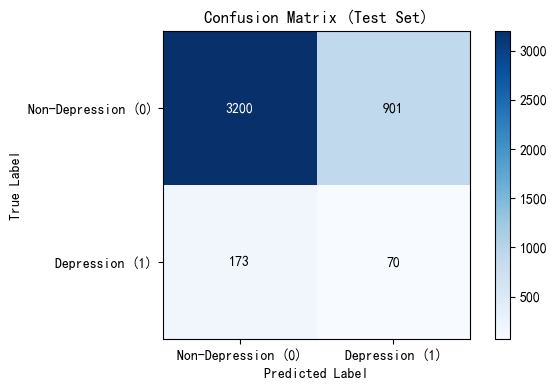

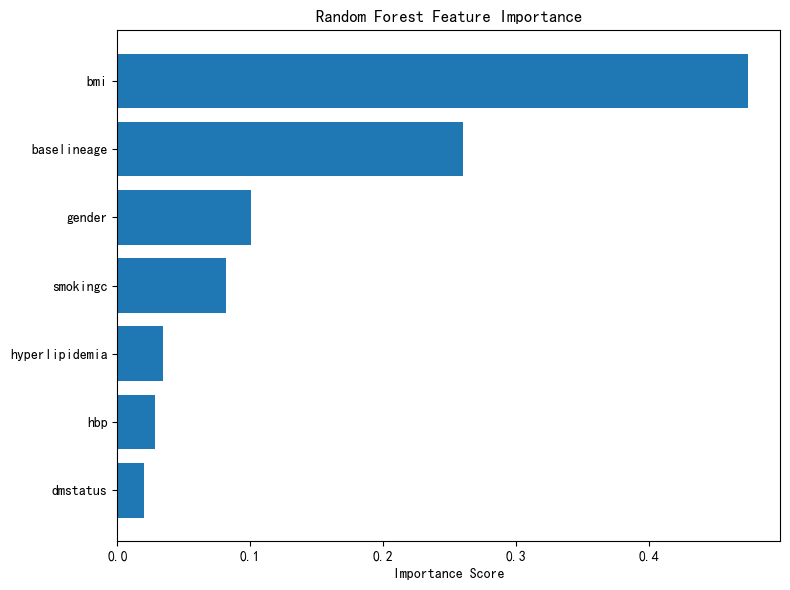

In [53]:
# 用随机森林利用表格数据进行抑郁分类

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ===================== 1. 配置文件路径 =====================
# 实际文件路径
JSON_PATH = "D:/LingYi/to_邹玉涛/fundus_depression/ukb_dataset/v2_data_splits/baseline_depression_data_split.json"  # 划分信息的JSON文件
FILLED_EXCEL_PATH = "D:/LingYi/to_邹玉涛/fundus_depression/filled_data_excel/filled_ukb_dataset.xlsx"  # 填充后的UKB表格
FEATURE_COLS = [  # 用于分类的特征列（与填充后的表格列名一致）
    "smokingc", "gender", "baselineage", "bmi", 
    "hyperlipidemia", "hbp", "dmstatus"
]
RANDOM_SEED = 42  # 随机种子，保证结果可复现

# ===================== 2. 读取并解析JSON文件 =====================
def parse_ukb_json(json_path):
    """
    解析JSON文件，提取train/val/test的样本ID、划分标签和抑郁标签（gt_label）
    返回：字典 {split: {"ids": [], "labels": []}}
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    split_info = {}
    for split in ["train", "val", "test"]:
        split_data = data[split]["data"]
        ids = []
        labels = []
        for sample_id, sample_info in split_data.items():
            # 提取gt_label：优先取right的gt_label（也可选择left或取平均）
            if sample_info.get("right") and len(sample_info["right"]) > 0:
                gt_label = sample_info["right"][0]["gt_label"]
            elif sample_info.get("left") and len(sample_info["left"]) > 0:
                gt_label = sample_info["left"][0]["gt_label"]
            else:
                print(f"警告：样本{sample_id}无gt_label，跳过")
                continue
            ids.append(sample_id)
            labels.append(gt_label)
        split_info[split] = {
            "ids": ids,
            "labels": labels
        }
        print(f"解析{split}集：共{len(ids)}个样本，阳性标签数{sum(labels)}")
    return split_info

# 执行解析
split_info = parse_ukb_json(JSON_PATH)

# ===================== 3. 读取填充后的UKB表格 =====================
def load_filled_ukb(excel_path):
    """读取填充后的UKB表格，处理eid_ckd列以匹配JSON的样本ID"""
    df = pd.read_excel(excel_path)
    # 确保eid_ckd为字符串类型（JSON中的ID是字符串）
    df["eid_ckd"] = df["eid_ckd"].astype(str)
    # 检查特征列是否存在
    missing_cols = [col for col in FEATURE_COLS if col not in df.columns]
    if missing_cols:
        raise ValueError(f"表格中缺失特征列：{missing_cols}")
    print(f"读取填充后的UKB表格：共{len(df)}行，特征列{FEATURE_COLS}")
    return df

# 执行读取
df_filled = load_filled_ukb(FILLED_EXCEL_PATH)

# ===================== 4. 匹配特征和标签，生成训练/验证/测试集 =====================
def create_datasets(df, split_info, feature_cols):
    """
    根据split_info匹配特征和标签，生成X_train/X_val/X_test, y_train/y_val/y_test
    """
    datasets = {}
    for split in ["train", "val", "test"]:
        ids = split_info[split]["ids"]
        labels = split_info[split]["labels"]
        # 按ID筛选表格中的数据
        df_split = df[df["eid_ckd"].isin(ids)].copy()
        # 按ID顺序匹配标签（确保ID和标签一一对应）
        id_label_map = dict(zip(ids, labels))
        df_split["gt_label"] = df_split["eid_ckd"].map(id_label_map)
        # 去除标签缺失的行（可能ID在JSON中但表格中无数据）
        df_split = df_split.dropna(subset=["gt_label"])
        # 提取特征和标签
        X = df_split[feature_cols]
        y = df_split["gt_label"].astype(int)
        datasets[split] = (X, y)
        print(f"{split}集：匹配到{len(X)}个样本（原始{len(ids)}个），阳性标签数{sum(y)}")
    return datasets

# 执行数据集生成
datasets = create_datasets(df_filled, split_info, FEATURE_COLS)
X_train, y_train = datasets["train"]
X_val, y_val = datasets["val"]
X_test, y_test = datasets["test"]

# ===================== 5. 数据预处理 =====================
def preprocess_data(X_train, X_val, X_test):
    """
    数据预处理：填充剩余缺失值（若有）、特征标准化（随机森林可选，但建议处理）
    """
    # 1. 填充缺失值（使用中位数填充数值特征）
    imputer = SimpleImputer(strategy="median")
    X_train_imputed = imputer.fit_transform(X_train)
    X_val_imputed = imputer.transform(X_val)
    X_test_imputed = imputer.transform(X_test)
    
    # 2. 特征标准化（随机森林对数值缩放不敏感，可注释此步骤）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_val_scaled = scaler.transform(X_val_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    print("数据预处理完成：缺失值填充+标准化")
    return X_train_scaled, X_val_scaled, X_test_scaled, imputer, scaler

# 执行预处理
X_train_scaled, X_val_scaled, X_test_scaled, imputer, scaler = preprocess_data(X_train, X_val, X_test)

# ===================== 6. 训练随机森林分类器 =====================
def train_random_forest(X_train, y_train, X_val, y_val, random_seed):
    """
    训练随机森林，使用验证集评估并调整参数
    """
    # 定义随机森林模型（可根据需求调整参数）
    rf = RandomForestClassifier(
        n_estimators=200,  # 决策树数量
        max_depth=10,      # 树的最大深度
        class_weight="balanced",  # 处理类别不平衡
        random_state=random_seed,
        n_jobs=-1  # 并行计算
    )
    
    # 训练模型
    rf.fit(X_train, y_train)
    
    # 验证集预测
    y_val_pred = rf.predict(X_val)
    y_val_pred_proba = rf.predict_proba(X_val)[:, 1]
    
    # 验证集评估
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, zero_division=0)
    val_recall = recall_score(y_val, y_val_pred, zero_division=0)
    val_f1 = f1_score(y_val, y_val_pred, zero_division=0)
    val_auc = roc_auc_score(y_val, y_val_pred_proba) if len(set(y_val)) > 1 else 0.5
    
    print("\n=== 验证集模型评估 ===")
    print(f"准确率(Accuracy)：{val_accuracy:.4f}")
    print(f"精确率(Precision)：{val_precision:.4f}")
    print(f"召回率(Recall)：{val_recall:.4f}")
    print(f"F1值(F1-Score)：{val_f1:.4f}")
    print(f"AUC值：{val_auc:.4f}")
    
    return rf, (val_accuracy, val_precision, val_recall, val_f1, val_auc)

# 执行训练
rf_model, val_metrics = train_random_forest(X_train_scaled, y_train, X_val_scaled, y_val, RANDOM_SEED)

# ===================== 7. 测试集评估 =====================
def evaluate_test_set(model, X_test, y_test):
    """测试集评估模型性能，输出详细指标和混淆矩阵"""
    # 测试集预测
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 计算评估指标
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    test_auc = roc_auc_score(y_test, y_test_pred_proba) if len(set(y_test)) > 1 else 0.5
    test_cm = confusion_matrix(y_test, y_test_pred)
    
    print("\n=== 测试集模型评估 ===")
    print(f"准确率(Accuracy)：{test_accuracy:.4f}")
    print(f"精确率(Precision)：{test_precision:.4f}")
    print(f"召回率(Recall)：{test_recall:.4f}")
    print(f"F1值(F1-Score)：{test_f1:.4f}")
    print(f"AUC值：{test_auc:.4f}")
    print(f"混淆矩阵：\n{test_cm}")
    
    # 可视化混淆矩阵（可选）
    plt.figure(figsize=(6, 4))
    plt.imshow(test_cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Test Set)")
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks([0, 1], ["Non-Depression (0)", "Depression (1)"])
    plt.yticks([0, 1], ["Non-Depression (0)", "Depression (1)"])
    # 标注数值
    for i in range(2):
        for j in range(2):
            plt.text(j, i, test_cm[i, j], ha="center", va="center", color="white" if test_cm[i, j] > test_cm.max()/2 else "black")
    plt.tight_layout()
    plt.show()
    
    # 特征重要性可视化
    feature_importance = model.feature_importances_
    feature_names = FEATURE_COLS
    sorted_idx = np.argsort(feature_importance)
    
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.title("Random Forest Feature Importance")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()
    
    return {
        "accuracy": test_accuracy,
        "precision": test_precision,
        "recall": test_recall,
        "f1": test_f1,
        "auc": test_auc,
        "confusion_matrix": test_cm
    }

# 执行测试集评估
test_metrics = evaluate_test_set(rf_model, X_test_scaled, y_test)

# ===================== 8. 保存模型（可选） =====================
import joblib
def save_model(model, imputer, scaler, save_path="./"):
    """保存训练好的模型、填充器和标准化器"""
    joblib.dump(model, save_path + "rf_depression_model.pkl")
    joblib.dump(imputer, save_path + "imputer.pkl")
    joblib.dump(scaler, save_path + "scaler.pkl")
    print(f"模型已保存至：{save_path}")

# 执行保存（可选）
# save_model(rf_model, imputer, scaler)

In [4]:
# SE-ResNet50网络进行图像质量评估，此部分进行MSHF数据集图片与标签的提取、训练集、验证集与测试集的划分

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR

# ===================== 1. 全局配置 =====================
# excel和图片实际路径
EXCEL_PATH = "D:/LingYi/to_邹玉涛/图像质量分类/MSHF dataset 2.0/MSHF dataset 2.0/MSHF_quality_scores.xlsx"  # 标签Excel文件
IMAGE_ROOT = "D:/LingYi/to_邹玉涛/图像质量分类/MSHF dataset 2.0/MSHF dataset 2.0/Original/CFP"  # 图片根目录（包含DR-ZJU-NEW、DR-XJU、Glaucoma、Healthy子文件夹）
# Excel中需要读取的Sheet名称
SHEET_NAMES = ["DR-ZJU-NEW", "DR-XJU", "Glaucoma", "Healthy"]
# 模型与训练配置
IMG_SIZE = 224  # SE-ResNet50输入尺寸
TRAIN_TEST_SPLIT = 0.8  # 训练集比例
RANDOM_SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备：{DEVICE}")

# 固定随机种子
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(RANDOM_SEED)

# ===================== 2. 读取Excel并匹配图片路径 =====================
def load_excel_and_match_images(excel_path, sheet_names, image_root):
    """
    读取Excel多Sheet数据，提取image name和Overall标签，匹配图片路径
    :return: 包含img_path和label的DataFrame
    """
    all_data = []
    for sheet in sheet_names:
        # 读取Sheet（header=0表示第一行为表头）
        df = pd.read_excel(excel_path, sheet_name=sheet, header=0)
        # 清理列名（去除空格/制表符）
        df.columns = df.columns.str.strip()
        # 提取关键列：image name和Overall
        df = df[["image name", "Overall"]].copy()
        # 去除缺失值
        df = df.dropna(subset=["image name", "Overall"])
        # 转换Overall为整数（0/1）
        df["Overall"] = df["Overall"].astype(int)
        # 匹配图片路径：根据image name前缀找到对应文件夹
        def get_img_path(img_name):
            # 提取文件夹前缀（如DR-ZJU-1.jpg → DR-ZJU）
            if len(img_name.split("-"))>=3:
                folder_prefix = img_name.split("-")[0] + "-" + img_name.split("-")[1]                
            else:
                folder_prefix = img_name.split("-")[0]
            img_path = os.path.join(image_root, folder_prefix, img_name)
            return img_path if os.path.exists(img_path) else None
        
        df["img_path"] = df["image name"].apply(get_img_path)
        # 过滤不存在的图片
        df = df.dropna(subset=["img_path"])
        all_data.append(df)
        print(f"Sheet {sheet}：加载{len(df)}张有效图片，正类（1）{sum(df['Overall'])}张，负类（0）{len(df)-sum(df['Overall'])}张")
    
    # 合并所有Sheet数据
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"\n总数据：{len(combined_df)}张有效图片，正类{sum(combined_df['Overall'])}张，负类{len(combined_df)-sum(combined_df['Overall'])}张")
    return combined_df

# 执行数据加载
df = load_excel_and_match_images(EXCEL_PATH, SHEET_NAMES, IMAGE_ROOT)
# 提取图片路径和标签
img_paths = df["img_path"].tolist()
labels = df["Overall"].tolist()

# 划分训练/测试集（分层抽样，保证类别分布一致）
train_paths, temp_paths, train_labels, temp_labels  = train_test_split(
    img_paths, labels, train_size=TRAIN_TEST_SPLIT, random_state=RANDOM_SEED, stratify=labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, 
    test_size=0.5,          # 临时集中50%为测试集，50%为验证集
    random_state=42,
    stratify=temp_labels    # 继续分层抽样
)

# 打印划分结果
print(f"训练集：{len(train_paths)}张，正类{train_labels.count(1)}，负类{train_labels.count(0)}")
print(f"验证集：{len(val_paths)}张，正类{val_labels.count(1)}，负类{val_labels.count(0)}")
print(f"测试集：{len(test_paths)}张，正类{test_labels.count(1)}，负类{test_labels.count(0)}")

使用设备：cuda


FileNotFoundError: [Errno 2] No such file or directory: 'D:/LingYi/to_邹玉涛/图像质量分类/MSHF dataset 2.0/MSHF dataset 2.0/MSHF_quality_scores.xlsx'

In [55]:
# # SE-ResNet50网络进行图像质量评估，此部分进行ukb_v0数据集图片与标签的提取、训练集、验证集与测试集的划分

# ===================== 1. 配置参数 =====================
# 根目录（ukb_v0的路径，替换为你的实际路径）
ROOT_DIR = r"D:\LingYi\to_邹玉涛\图像质量分类\ukb_v0"
# 文件夹与标签的映射：key=文件夹名，value=标签
FOLDER_LABEL_MAP = {
    "left": 1,
    "right": 1,
    "left_dark1328": 0,
    "right_dark1598": 0
}
# 支持的图片格式
SUPPORTED_FORMATS = (".jpg", ".jpeg", ".png", ".bmp")
# 随机种子（保证采样和划分可复现）
RANDOM_SEED = 42
# 数据集划分比例：训练集80%，验证集10%，测试集10%
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# 固定随机种子
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ===================== 2. 遍历文件夹，收集图片路径和标签 =====================
def collect_img_paths_and_labels(root_dir, folder_label_map, supported_formats):
    """
    遍历指定文件夹，收集图片路径和对应标签
    :return: 正类路径列表（label=1）、负类路径列表（label=0）
    """
    pos_paths = []  # 标签1的图片路径（left/right）
    neg_paths = []  # 标签0的图片路径（left_dark1328/right_dark1598）
    
    # 遍历根目录下的目标文件夹
    for folder_name, label in folder_label_map.items():
        folder_path = os.path.join(root_dir, folder_name)
        if not os.path.exists(folder_path):
            print(f"警告：文件夹{folder_path}不存在，跳过")
            continue
        
        # 遍历文件夹中的图片
        for file in os.listdir(folder_path):
            # 筛选支持的图片格式
            if file.lower().endswith(supported_formats):
                img_path = os.path.join(folder_path, file)
                # 验证图片是否可读取（过滤损坏图片）
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # 验证图片完整性
                    if label == 1:
                        pos_paths.append(img_path)
                    else:
                        neg_paths.append(img_path)
                except Exception as e:
                    print(f"跳过损坏图片：{img_path}，错误：{str(e)[:50]}")
    
    print(f"原始数据统计：")
    print(f"正类（left/right）：{len(pos_paths)}张")
    print(f"负类（left_dark1328/right_dark1598）：{len(neg_paths)}张")
    return pos_paths, neg_paths

# 执行收集
pos_paths, neg_paths = collect_img_paths_and_labels(ROOT_DIR, FOLDER_LABEL_MAP, SUPPORTED_FORMATS)

# ===================== 3. 对正类进行降采样，使正负类比例接近1:1 =====================
def downsample_positive(pos_paths, neg_paths, random_seed):
    """
    对正类进行随机降采样，数量与负类一致
    :return: 降采样后的正类路径、负类路径（保持不变）
    """
    neg_num = len(neg_paths)
    pos_num = len(pos_paths)
    
    if pos_num <= neg_num:
        print(f"正类数量{pos_num}≤负类数量{neg_num}，无需降采样")
        return pos_paths, neg_paths
    else:
        print(f"正类数量{pos_num}＞负类数量{neg_num}，进行降采样至{neg_num}张")
        # 随机抽取neg_num个正类样本
        pos_sampled = random.sample(pos_paths, neg_num)
        return pos_sampled, neg_paths

# 执行降采样
pos_sampled, neg_sampled = downsample_positive(pos_paths, neg_paths, RANDOM_SEED)

# 合并降采样后的所有数据
all_paths = pos_sampled + neg_sampled
all_labels = [1]*len(pos_sampled) + [0]*len(neg_sampled)
print(f"\n降采样后数据统计：")
print(f"总样本数：{len(all_paths)}张，正类{len(pos_sampled)}张，负类{len(neg_sampled)}张，比例{len(pos_sampled)}:{len(neg_sampled)}")

# ===================== 4. 分层划分训练集、验证集、测试集 =====================
def split_train_val_test(all_paths, all_labels, train_ratio, val_ratio, test_ratio, random_seed):
    """
    分层划分数据集，保证各集合类别分布一致
    :return: 训练/验证/测试集的路径和标签
    """
    # 校验比例和为1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "比例和必须为1"
    
    # 第一步：划分训练集（train_ratio）和临时集（val+test）
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_paths, all_labels,
        train_size=train_ratio,
        random_state=random_seed,
        stratify=all_labels  # 分层抽样，保证类别分布
    )
    
    # 第二步：划分验证集和测试集（按val_ratio/(val_ratio+test_ratio)比例）
    val_test_ratio = val_ratio / (val_ratio + test_ratio)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels,
        train_size=val_test_ratio,
        random_state=random_seed,
        stratify=temp_labels  # 继续分层抽样
    )
    
    # 打印划分结果
    print(f"\n数据集划分结果：")
    print(f"训练集：{len(train_paths)}张，正类{train_labels.count(1)}，负类{train_labels.count(0)}")
    print(f"验证集：{len(val_paths)}张，正类{val_labels.count(1)}，负类{val_labels.count(0)}")
    print(f"测试集：{len(test_paths)}张，正类{test_labels.count(1)}，负类{test_labels.count(0)}")
    
    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

# 执行划分
train_set, val_set, test_set = split_train_val_test(
    all_paths, all_labels,
    TRAIN_RATIO, VAL_RATIO, TEST_RATIO,
    RANDOM_SEED
)

# 提取各集合的路径和标签（供后续模型训练使用）
train_paths, train_labels = train_set
val_paths, val_labels = val_set
test_paths, test_labels = test_set

原始数据统计：
正类（left/right）：21072张
负类（left_dark1328/right_dark1598）：2926张
正类数量21072＞负类数量2926，进行降采样至2926张

降采样后数据统计：
总样本数：5852张，正类2926张，负类2926张，比例2926:2926

数据集划分结果：
训练集：4681张，正类2341，负类2340
验证集：585张，正类292，负类293
测试集：586张，正类293，负类293


In [58]:
# 数据集预处理与模型构建
# 参数设置
EPOCHS = 5
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 32

# ===================== 3. 自定义数据集类 =====================
class ImageQualityDataset(Dataset):
    """图像质量分类数据集"""
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        # 读取图片（RGB格式）
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"读取图片失败：{img_path}，错误：{e}")
            # 替换为空白图
            img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), (255, 255, 255))
        # 图像变换
        if self.transform:
            img = self.transform(img)
        # 转换标签为张量
        label = torch.tensor(label, dtype=torch.float32)
        return img, label

# ===================== 4. 图像预处理变换 =====================
# 训练集增强，测试集仅预处理
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet归一化
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 构建DataLoader
train_dataset = ImageQualityDataset(train_paths, train_labels, train_transform)
val_dataset = ImageQualityDataset(val_paths, val_labels, val_transform)
test_dataset = ImageQualityDataset(test_paths, test_labels, test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ===================== 5. SE-ResNet50模型构建 =====================
class SEResNet50(nn.Module):
    """融入Squeeze-and-Excitation注意力机制的ResNet50"""
    def __init__(self, num_classes=1, pretrained=True):
        super(SEResNet50, self).__init__()
        # 加载预训练ResNet50
        self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
        in_features = self.resnet.fc.in_features
        
        # SE注意力模块（通道注意力）
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # 全局平均池化
            nn.Flatten(),
            nn.Linear(in_features, in_features // 16),  # 降维
            nn.ReLU(inplace=True),
            nn.Linear(in_features // 16, in_features),  # 升维
            nn.Sigmoid()  # 生成通道权重
        )
        
        # 分类头（加入Dropout防止过拟合）
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        # ResNet特征提取
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        # 全局平均池化
        x_pool = self.resnet.avgpool(x)
        x_flat = torch.flatten(x_pool, 1)
        
        # SE注意力加权：对每个通道特征赋予权重
        se_weight = self.se(x)
        x_weighted = x_flat * se_weight
        
        # 分类输出（logits，二分类用sigmoid）
        out = self.fc(x_weighted)
        return out.squeeze(1)

# 初始化模型
model = SEResNet50(num_classes=1, pretrained=True).to(DEVICE)

# 损失函数：处理类别不平衡（计算正类权重）
pos_count = sum(train_labels)
neg_count = len(train_labels) - pos_count
pos_weight = torch.tensor([neg_count / pos_count]).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # 二分类交叉熵+类别权重

# 优化器：AdamW（带权重衰减）
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# 学习率调度器：余弦退火
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

In [59]:
# 训练与保存模型

# ===================== 6. 训练与验证函数 =====================
def train_one_epoch(model, loader, criterion, optimizer, device):
    """训练单个epoch"""
    model.train()
    total_loss = 0.0
    pbar = tqdm(loader, desc="Training")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        # 前向传播
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 统计损失
        total_loss += loss.item() * imgs.size(0)
        pbar.set_postfix({"loss": loss.item()})
    return total_loss / len(loader.dataset)

def validate(model, loader, criterion, device):
    """验证模型并计算评估指标"""
    model.eval()
    total_loss = 0.0
    all_probs = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating")
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            # 计算预测概率和标签（阈值0.5）
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            # 收集结果
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix({"loss": loss.item()})
    # 转换为数组
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    # 计算评估指标
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    # 计算特异性
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0    
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.5
    return total_loss / len(loader.dataset), acc, f1, auc, precision, recall, specificity

# ===================== 7. 训练主循环 =====================
best_f1 = 0.0  # 保存最优F1值的模型
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")
    # 训练
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    train_losses.append(train_loss)
    # 验证
    val_loss, val_acc, val_f1, val_auc, val_prec, val_rec, val_spc = validate(model, val_loader, criterion, DEVICE)
    val_losses.append(val_loss)
    # 学习率调度
    scheduler.step()
    # 保存最优模型
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_seresnet_quality.pth")
        print(f"保存最优模型，当前F1：{val_f1:.4f}")
    # 打印指标
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Val Acc: {val_acc:.4f} | Val Pre: {val_prec:.4f} | Val Rec: {val_rec:.4f} | Val Spe: {val_spc:.4f} | Val F1: {val_f1:.4f} | Val AUC: {val_auc:.4f}")

# 测试    
# 加载最优模型
# ===================== 8. 加载模型 =====================
# 模型权重路径（训练时保存的best_seresnet_quality.pth）
MODEL_WEIGHTS_PATH = "./best_seresnet_quality.pth"
def load_model(weights_path, device):
    """加载训练好的SE-ResNet50模型"""
    model = SEResNet50(num_classes=1, pretrained=False).to(device)
    # 加载权重（忽略预训练权重的匹配警告）
    checkpoint = torch.load(weights_path, map_location=device)
    model.load_state_dict(checkpoint, strict=True)
    # 设为评估模式
    model.eval()
    print(f"模型权重加载成功：{weights_path}")
    return model

model = load_model(MODEL_WEIGHTS_PATH, DEVICE)
test_loss, test_acc, test_f1, test_auc, test_prec, test_rec, test_spc = validate(model, test_loader, criterion, DEVICE)
print("测试结果：\n")
print(f"Test Acc: {test_acc:.4f} | Tset Pre: {test_prec:.4f} | Test Rec: {test_rec:.4f} | Test Spe: {test_spc:.4f} | Test F1: {test_f1:.4f} | Test AUC: {test_auc:.4f}")



Epoch [1/5]


Validating: 100%|█████████████████████████████████████████████████████████| 19/19 [00:21<00:00,  1.15s/it, loss=0.0884]


保存最优模型，当前F1：0.9134
Train Loss: 0.2124 | Val Loss: 0.1812
Val Acc: 0.9128 | Val Pre: 0.9057 | Val Rec: 0.9212 | Val Spe: 0.9044 | Val F1: 0.9134 | Val AUC: 0.9790

Epoch [2/5]


Validating: 100%|██████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it, loss=0.116]


保存最优模型，当前F1：0.9168
Train Loss: 0.1616 | Val Loss: 0.1886
Val Acc: 0.9128 | Val Pre: 0.8754 | Val Rec: 0.9623 | Val Spe: 0.8635 | Val F1: 0.9168 | Val AUC: 0.9845

Epoch [3/5]


Validating: 100%|█████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it, loss=0.0495]


保存最优模型，当前F1：0.9336
Train Loss: 0.1464 | Val Loss: 0.1672
Val Acc: 0.9316 | Val Pre: 0.9065 | Val Rec: 0.9623 | Val Spe: 0.9010 | Val F1: 0.9336 | Val AUC: 0.9868

Epoch [4/5]


Validating: 100%|█████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it, loss=0.0356]


保存最优模型，当前F1：0.9490
Train Loss: 0.1148 | Val Loss: 0.1480
Val Acc: 0.9487 | Val Pre: 0.9426 | Val Rec: 0.9555 | Val Spe: 0.9420 | Val F1: 0.9490 | Val AUC: 0.9879

Epoch [5/5]


Validating: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.01s/it, loss=0.03]


Train Loss: 0.1001 | Val Loss: 0.1405
Val Acc: 0.9436 | Val Pre: 0.9420 | Val Rec: 0.9452 | Val Spe: 0.9420 | Val F1: 0.9436 | Val AUC: 0.9879
模型权重加载成功：./best_seresnet_quality.pth


Validating: 100%|████████████████████████████████████████████████████████| 19/19 [00:18<00:00,  1.02it/s, loss=0.00641]

测试结果：

Test Acc: 0.9369 | Tset Pre: 0.9414 | Test Rec: 0.9317 | Test Spe: 0.9420 | Test F1: 0.9365 | Test AUC: 0.9850


In [60]:
# 用训练好的模型预测ukb_dataset中的left和right图形质量并输出txt文档

# ===================== 1. 配置参数 =====================
# UKB数据集图片根路径（包含left和right子文件夹）
UKB_IMAGE_ROOT = r"D:\LingYi\to_邹玉涛\fundus_depression\ukb_dataset\images"
# 输出结果的txt路径
OUTPUT_TXT_PATH = "./train_by_ukb_v0_ukb_quality_predictions.txt"
# 模型与预处理配置
IMG_SIZE = 224  # 与训练时一致
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 支持的图片格式
SUPPORTED_FORMATS = (".jpg", ".jpeg", ".png", ".bmp")

# ===================== 3. 图片预处理 =====================
def get_image_transform():
    """获取与测试集一致的图片预处理变换"""
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet归一化参数，与训练时一致
                             std=[0.229, 0.224, 0.225])
    ])
    return transform

TARGET_SUBDIRS = {"left", "right"}
# ===================== 4. 遍历获取所有图片路径 =====================
def get_all_image_paths(root_dir):
    """递归遍历文件夹，仅获取left/right子文件夹中支持格式的图片路径"""
    img_paths = []  # 初始化空列表，存储有效图片路径
    # 递归遍历根目录下的所有子目录和文件
    for subdir, _, files in os.walk(root_dir):
        # 提取当前子目录的最后一级名称（如D:\xxx\left → left）
        subdir_basename = os.path.basename(subdir).lower()
        # 仅处理名称为left/right的子文件夹
        if subdir_basename in TARGET_SUBDIRS:
            # 遍历当前子目录下的所有文件
            for file in files:
                # 筛选支持的图片格式（转小写避免大小写问题）
                if file.lower().endswith(SUPPORTED_FORMATS):
                    # 拼接图片的完整路径
                    img_path = os.path.join(subdir, file)
                    # 将有效路径加入列表
                    img_paths.append(img_path)
    # 打印找到的图片总数
    print(f"在left/right子文件夹中共找到{len(img_paths)}张图片")
    return img_paths

# ===================== 5. 单张图片预测 =====================
def predict_single_image(img_path, model, transform, device):
    """
    预测单张图片的质量标签
    :return: label (0/1) 或 None（图片损坏时）
    """
    try:
        # 读取图片并转换为RGB（处理灰度图/透明图）
        img = Image.open(img_path).convert("RGB")
        # 预处理
        img_tensor = transform(img).unsqueeze(0)  # 添加batch维度 [1, 3, 224, 224]
        img_tensor = img_tensor.to(device)
        # 模型预测（关闭梯度计算）
        with torch.no_grad():
            logits = model(img_tensor)
            prob = torch.sigmoid(logits).item()  # 转换为概率
            label = 1 if prob > 0.5 else 0  # 阈值0.5分类
        return label
    except Exception as e:
        print(f"跳过损坏图片：{img_path}，错误：{str(e)[:50]}")
        return None

# ===================== 6. 批量预测并保存结果 =====================
def batch_predict_and_save():
    # 1. 初始化模型和预处理
    model = load_model(MODEL_WEIGHTS_PATH, DEVICE)
    transform = get_image_transform()
    # 2. 获取所有图片路径
    img_paths = get_all_image_paths(UKB_IMAGE_ROOT)
    # 3. 打开txt文件准备写入
    with open(OUTPUT_TXT_PATH, "w", encoding="utf-8") as f:
        # 写入表头（可选）
        f.write("image_path,label\n")
        # 批量预测
        for img_path in tqdm(img_paths, desc="预测中"):
            label = predict_single_image(img_path, model, transform, DEVICE)
            if label is not None:
                # 按格式写入：绝对路径, 标签
                f.write(f"{img_path},{label}\n")
    print(f"预测完成！结果已保存至：{OUTPUT_TXT_PATH}")

# ===================== 主函数 =====================
if __name__ == "__main__":
    batch_predict_and_save()

模型权重加载成功：./best_seresnet_quality.pth
在left/right子文件夹中共找到86044张图片


预测中: 100%|██████████████████████████████████████████████████████████████████| 86044/86044 [1:36:24<00:00, 14.88it/s]

预测完成！结果已保存至：./train_by_ukb_v0_ukb_quality_predictions.txt


预测结果统计：正类（1）84331张，负类（0）1713张
随机抽样：正类10张，负类10张


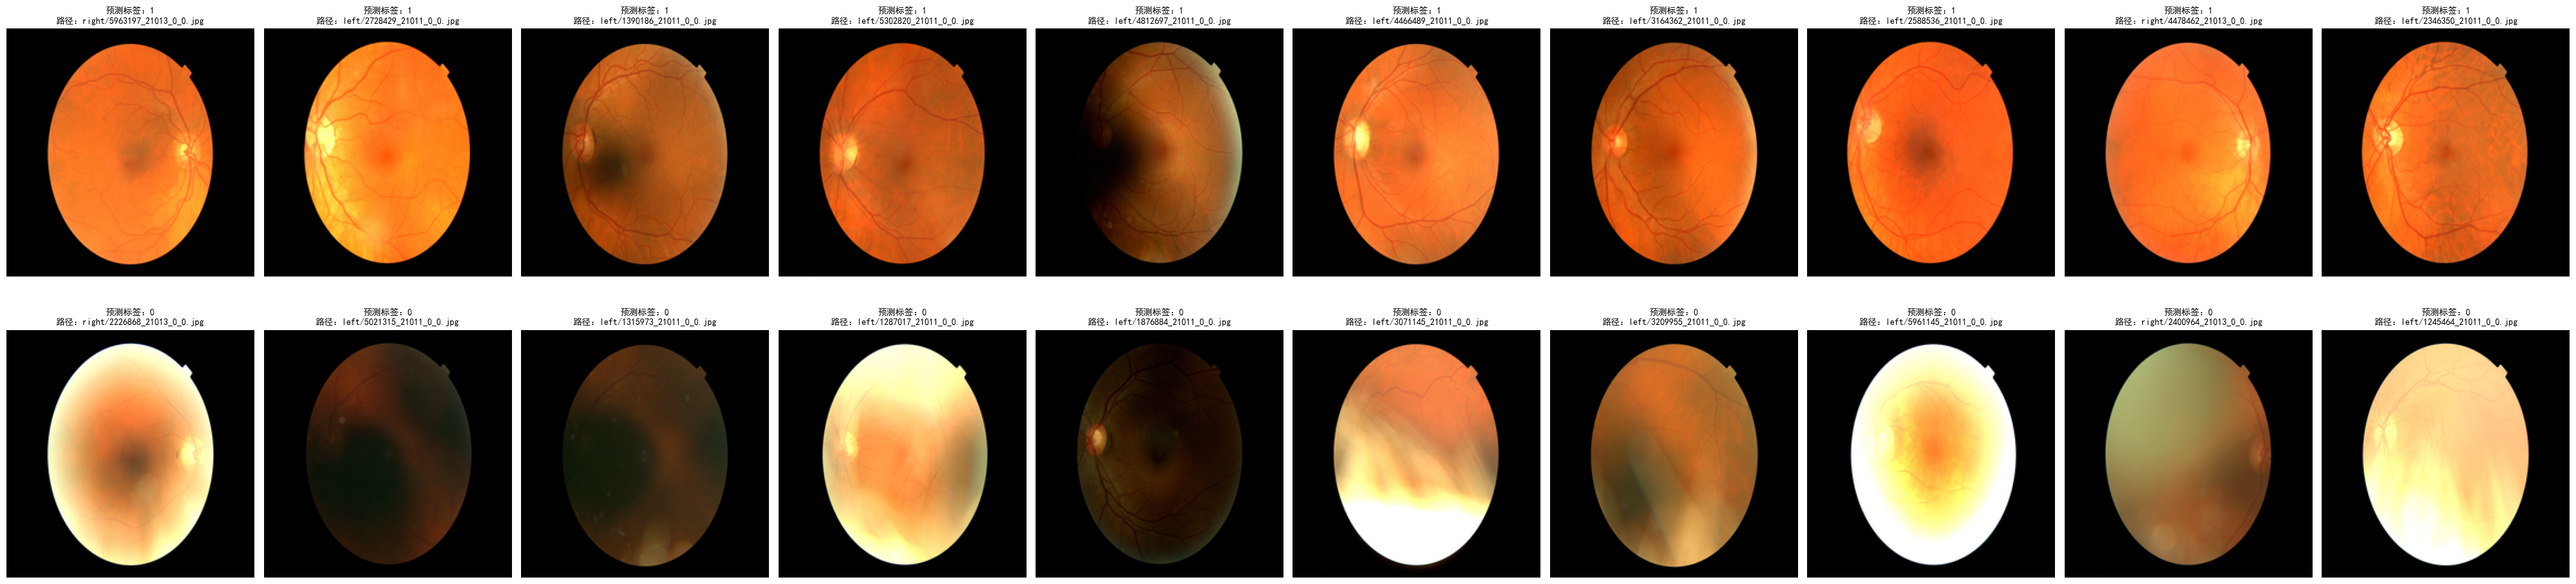

In [61]:
# 从预测好的txt文档中随机抽取20张（label 1:10张，label 0：10张）图片，可以进行人工检查

import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# ===================== 1. 配置参数 =====================
# 预测结果txt路径
PREDICTION_TXT_PATH = "./train_by_ukb_v0_ukb_quality_predictions.txt"
# 随机种子（保证抽样可复现）
RANDOM_SEED = 42
# 每类抽取的样本数
SAMPLE_NUM = 10
# 图片展示尺寸（宽高，单位：像素）
DISPLAY_SIZE = (224, 224)
# 解决matplotlib中文显示问题（Windows系统）
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 显示中文
plt.rcParams["axes.unicode_minus"] = False    # 显示负号

# 固定随机种子
random.seed(RANDOM_SEED)

# ===================== 2. 读取并解析预测结果 =====================
def load_prediction_results(txt_path):
    """
    读取预测结果txt，返回正类（1）和负类（0）的图片路径列表
    """
    # 读取txt为DataFrame
    df = pd.read_csv(txt_path)
    # 筛选正类和负类
    pos_paths = df[df["label"] == 1]["image_path"].tolist()  # 标签1的图片路径
    neg_paths = df[df["label"] == 0]["image_path"].tolist()  # 标签0的图片路径
    print(f"预测结果统计：正类（1）{len(pos_paths)}张，负类（0）{len(neg_paths)}张")
    return pos_paths, neg_paths

# ===================== 3. 随机抽样 =====================
def random_sample_paths(pos_paths, neg_paths, sample_num):
    """
    从正/负类中各随机抽取指定数量的图片路径
    """
    # 正类抽样（不足则取全部）
    sample_pos = random.sample(pos_paths, min(sample_num, len(pos_paths)))
    # 负类抽样（不足则取全部）
    sample_neg = random.sample(neg_paths, min(sample_num, len(neg_paths)))
    print(f"随机抽样：正类{len(sample_pos)}张，负类{len(sample_neg)}张")
    return sample_pos, sample_neg

# ===================== 4. 可视化抽样结果 =====================
def visualize_samples(sample_pos, sample_neg):
    """
    展示抽样的正类和负类图片，标注路径和预测标签
    """
    # 合并抽样结果，记录标签
    all_samples = []
    for path in sample_pos:
        all_samples.append((path, 1))
    for path in sample_neg:
        all_samples.append((path, 0))
    
    # 计算子图行列数（按2行展示，列数为实际样本数的一半）
    total_samples = len(all_samples)
    rows = 2
    cols = (total_samples + 1) // rows  # 向上取整
    
    # 创建画布
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*5))
    axes = axes.flatten()  # 展平axes，方便遍历
    
    # 遍历展示每张图片
    for idx, (img_path, label) in enumerate(all_samples):
        ax = axes[idx]
        try:
            # 读取图片并调整显示尺寸
            img = Image.open(img_path).convert("RGB")
            img = img.resize(DISPLAY_SIZE, Image.Resampling.LANCZOS)
            # 显示图片
            ax.imshow(img)
            # 标注图片路径和预测标签（截断长路径，只保留最后部分）
            short_path = os.path.basename(os.path.dirname(img_path)) + "/" + os.path.basename(img_path)
            ax.set_title(f"预测标签：{label}\n路径：{short_path}", fontsize=10)
        except Exception as e:
            # 图片损坏时显示错误信息
            ax.text(0.5, 0.5, f"图片读取失败\n{str(e)[:20]}", ha="center", va="center")
            ax.set_title(f"预测标签：{label}\n路径：{os.path.basename(img_path)}", fontsize=10)
        ax.axis("off")  # 关闭坐标轴
    
    # 隐藏多余的子图
    for idx in range(len(all_samples), len(axes)):
        axes[idx].axis("off")
    
    # 调整子图间距
    plt.tight_layout()
    # 保存可视化结果（可选）
    plt.savefig("./sample_prediction_check.png", dpi=300, bbox_inches="tight")
    # 显示图片
    plt.show()

# ===================== 主函数 =====================
if __name__ == "__main__":
    # 1. 读取预测结果
    pos_paths, neg_paths = load_prediction_results(PREDICTION_TXT_PATH)
    # 2. 随机抽样
    sample_pos, sample_neg = random_sample_paths(pos_paths, neg_paths, SAMPLE_NUM)
    # 3. 可视化展示
    visualize_samples(sample_pos, sample_neg)